In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from cnnlib import utils, data_utils, functions
import torch.nn.functional as F

### Constants

In [2]:
BATCH_SIZE = 256
NUM_OF_DATASET_WORKERS = 2
DATA_SET_DIR = "../../data"
DEVICE = utils.getDevice()

print(f'Using device - {DEVICE}')

Using device - cuda


### Download the CIFAR dataset

Files already downloaded and verified
Files already downloaded and verified
Number of train images: 50000
Number of test images: 10000


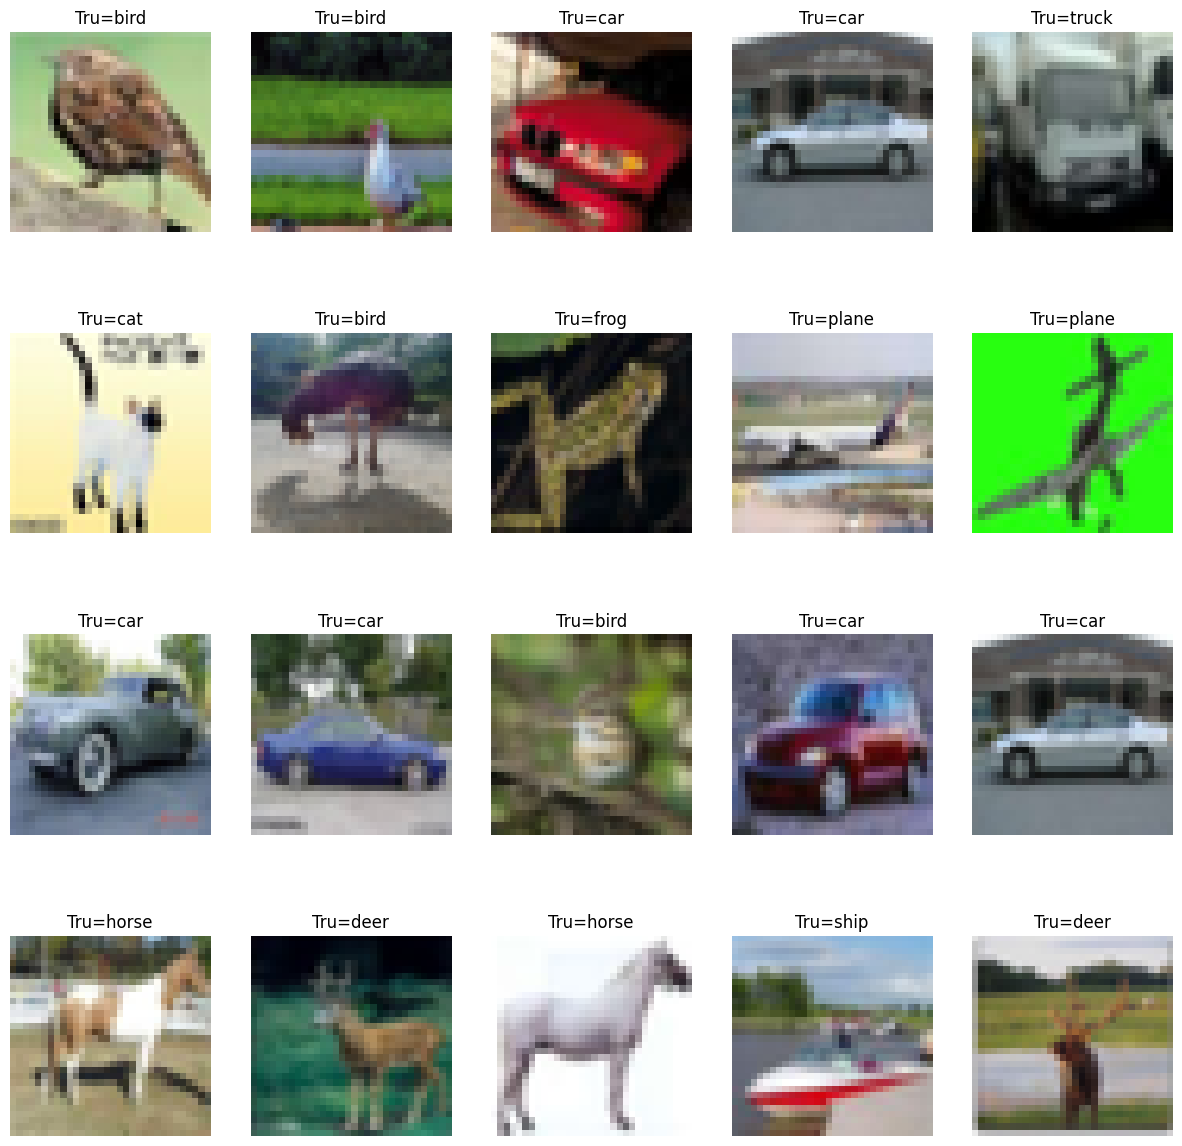

In [3]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ])

data = data_utils.download_CIFAR10(transform, transform, BATCH_SIZE)

data_utils.showLoaderImages(data.train, classes=data.classes, count=20, muSigmaPair=(mean, std))

### Load the model

In [4]:
from models import ultimus
import torch.nn as nn

net = ultimus.Net().to(DEVICE)
net.summarize((3, 32, 32))
criterion = nn.CrossEntropyLoss()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,608
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 48, 32, 32]          13,824
              ReLU-8           [-1, 48, 32, 32]               0
       BatchNorm2d-9           [-1, 48, 32, 32]              96
AdaptiveAvgPool2d-10             [-1, 48, 1, 1]               0
        Embedding-11             [-1, 48, 1, 1]               0
           Linear-12                    [-1, 8]             392
           Linear-13                    [-1, 8]             392
           Linear-14                   

### LR Finder

In [5]:
import torch.optim as optim
from cnnlib.lr_finder import LRFinder

optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay=0.01)
finder = LRFinder(net, optimizer, criterion, device="cuda")

finder.range_test(data.train, val_loader=data.test, start_lr=0.001, end_lr=1,
                     num_iter= 500, step_mode="exp")

  pip install torch-lr-finder -v --global-option="amp"
 75%|███████▍  | 373/500 [07:00<02:23,  1.13s/it]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


Best LR: 0.008165823713585924


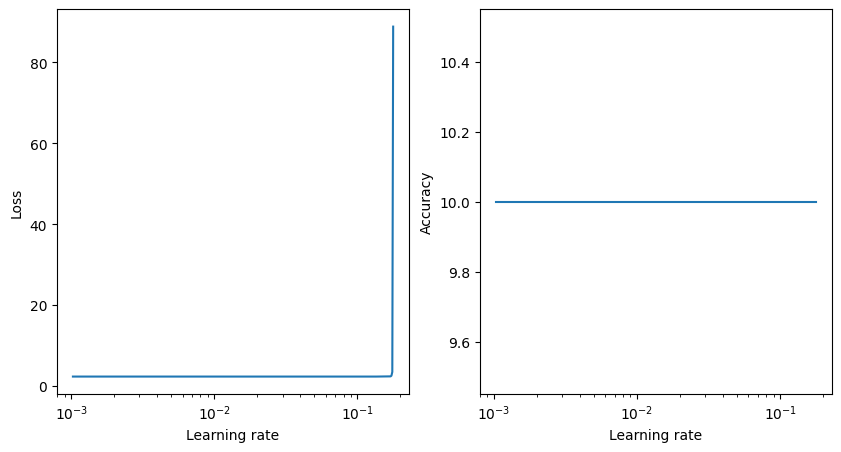

In [6]:
bestLR = finder.history["lr"][finder.history["loss"].index(finder.best_loss)]
print(f"Best LR: {bestLR}")

finder.plot()
finder.reset()

### Train the model

In [7]:
from torch.optim.lr_scheduler import OneCycleLR
from cnnlib.model_builder import ModelBuilder

EPOCH = 24

scheduler = OneCycleLR(optimizer, max_lr=bestLR, epochs=EPOCH, steps_per_epoch=len(data.train), 
                       pct_start=5/EPOCH, anneal_strategy='linear', div_factor=25.0, final_div_factor=1)
builder = ModelBuilder(net, data, criterion, optimizer, scheduler)
result = builder.fit(EPOCH)

ModuleNotFoundError: No module named 'cnnlib.model_builder'

### Plot metrics

In [ ]:
from cnnlib import metrics_utils
metrics_utils.plot(result)